# Computer Assigment 4 - PCA



* The goal of this project is to use PCA and Krnel PCA, as explained in the [Kernel Principal Component Analysis and its Applications inFace Recognition and Active Shape Models](https://arxiv.org/abs/1207.3538) paper to classify Human faces. 
* The procedure followed will match that of Chapter 3.2. Since the original link to the dataset was broken, we used the [Extended Yale Face Database B](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html), and downloaded the cropped Images, which are the ones used in the Paper.
* As the paper suggested, only subjects 1 and 3 were used, which is the ones we downloaded, and can be found in the corresponding folders.

## Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import os

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## Read Data

* The `yaleB01` and `yaleB03` directories should be located in the root directory of the notebook in order to read the data. These correspond to the first and third subject, as the paper suggests. We save the images as arrays under the `im` list, which is then converted into a numpy array.

In [56]:
# assign directory
directory = ['yaleB01', 'yaleB03']
 
im = [[],[]] 
# iterate over files in that directory
for i, dir in enumerate(directory):
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            with open(f, 'rb') as pgmf:
                im[i].append(plt.imread(pgmf).flatten())

im = np.array(im)
im.shape

(2, 64, 32256)

* Let's plot the first face of each subject. As we can see, in this extended dataset the images are cropped to the desired resolution (168x192) and aligned (again as the paper suggests).

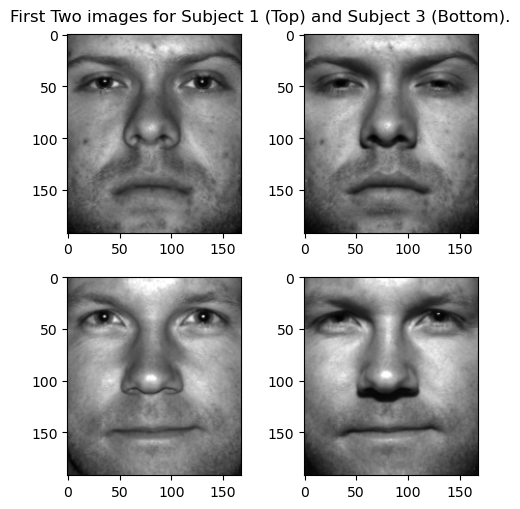

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(5,5))

for i, triaxes in enumerate(ax):
    for j,axes  in enumerate(triaxes):
        axes.imshow(im[i][j].reshape(192,168))

fig.tight_layout()
fig.suptitle('First Two images for Subject 1 (Top) and Subject 3 (Bottom).', fontsize=12, y=1.01)
plt.show()

## Train/Test split

* We will use 51 images as the training data, for each subject, and the remaining 13 will be used for Testing purposes.
* Data will be normalized.

In [62]:
# Define train/test split
X_train, X_test = im[:, :51, :].reshape((102,32256)), im[:, 51:, :].reshape((26,32256))
y_train, y_test = np.concatenate((np.zeros(51), np.ones(51))), np.concatenate((np.zeros(13), np.ones(13))) 

# Normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((102, 32256), (26, 32256))

## Standard PCA

* As suggested in the paper, where the 9 most significant features were extracted, we will perform PCA using 9 components. 
* `sk-learn` offers the [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) and [`KernelPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) classes under the [`decomposition`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) library.

In [63]:
pca = PCA(9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

qd = LinearDiscriminantAnalysis()
qd.fit(X_train_pca, y_train)
error_train = (1-accuracy_score(qd.predict(X_train_pca), y_train)) * 100
error_test = (1-accuracy_score(qd.predict(X_test_pca ), y_test)) * 100

## Kernel PCA

* For the kernel PCA a selection of $\sigma$ has to be made, which, in turn, defines $\gamma = \dfrac{1}{2\sigma^2}$. 

After various tests we concluded that in our expirement a value of 60 fetched the best results.

In [80]:
s = 60  
gamma = 1/(2*s**2)
kernel_pca  = KernelPCA(9, gamma=gamma, kernel='rbf')

X_train_kernel_pca = kernel_pca.fit_transform(X_train_scaled)
X_test_kernel_pca = kernel_pca.transform(X_test_scaled)


qd = LinearDiscriminantAnalysis()
qd.fit(X_train_kernel_pca, y_train)
error_kernel_train = (1-accuracy_score(qd.predict(X_train_kernel_pca), y_train)) * 100
error_kernel_test = (1-accuracy_score(qd.predict(X_test_kernel_pca), y_test)) * 100


# Results

* Having read the suggested book in the paper (*Krzanowski,Wojtek J. Principles of multivariate analysis. Clarendon, 2000.*) we came to the conclution that the classifier mentioned is in practice the [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) Classifier. In Practice it is a a classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.
* As we can see from the results, the KernelPCA method improved the error rate on the training data, but has no improvement on the Testing Data. Moreover, compared to the paper, we achieved better results in the training data, but worse in the testing Data.
* Finally there are deviation, between our method and the paper's. This is expected, since the data might have slight deviations and the classification algorithm is not specified in detail.

In [65]:
df = pd.DataFrame(columns=['Error Rate', 'PCA', 'Kernel PCA'], 
    data = [['Training Data', error_train, error_kernel_train ], ['Testing Data', error_test, error_kernel_test]])
df

,Error Rate,PCA,Kernel PCA
0,Training Data,3.921569,1.960784
1,Testing Data,34.615385,34.615385


## Improvements

Althought not in the scope of this assignment, it is worth noting that the results can easily be improved using some simple modifications. 

1. An exploration in the optimal number of components could possible fetch better results
2. Different kernels, in the KernelPCA, along with a parameter optimization could take place
3. The easiest way to get better results instantly is to just change the classification method. An example, using the existing data is show below. Just by changing the [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) to the [`QuadraticDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) we manage to achieve much metter result in both the training, as well as the test set, wihtout any optimization of the classifier.

In [110]:
# Simple PCA
logistic = QuadraticDiscriminantAnalysis()
logistic.fit(X_train_pca, y_train)
error_train = (1-accuracy_score(logistic.predict(X_train_pca), y_train)) * 100
error_test = (1-accuracy_score(logistic.predict(X_test_pca ), y_test)) * 100

# KernelPCA, 
s = 1000  
gamma = 1/(2*s**2)
kernel_pca  = KernelPCA(9, gamma=gamma, kernel='rbf')

X_train_kernel_pca = kernel_pca.fit_transform(X_train_scaled)
X_test_kernel_pca = kernel_pca.transform(X_test_scaled)

logistic = QuadraticDiscriminantAnalysis()
logistic.fit(X_train_kernel_pca, y_train)
error_kernel_train = (1-accuracy_score(logistic.predict(X_train_kernel_pca), y_train)) * 100
error_kernel_test = (1-accuracy_score(logistic.predict(X_test_kernel_pca), y_test)) * 100

df = pd.DataFrame(columns=['Error Rate', 'PCA', 'Kernel PCA'], 
    data = [['Training Data', error_train, error_kernel_train ], ['Testing Data', error_test, error_kernel_test]])
df

,Error Rate,PCA,Kernel PCA
0,Training Data,0.000000,0.000000
1,Testing Data,3.846154,3.846154
